In [1]:
from torch.utils.data import Dataset, random_split, DataLoader
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import random
from config import *

/home/zceemsi/AMLS_II_assignment22_23/venv/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class RSNA_Dataset(Dataset):
    def __init__(self, path, labels, transform=None):
        self.path = path
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_name = os.path.join(self.path,f"{self.labels.loc[index, 'patient_id']}_{self.labels.loc[index, 'image_id']}.png")
        img = Image.open(img_name)
        if self.transform is not None:
            img = self.transform(img)
        label = torch.tensor(self.labels.loc[index, 'cancer'])
        return img, label

In [51]:
# set up the transform pipeline for data augmentation
transform_pipeline = transforms.Compose([
    transforms.CenterCrop(1280),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=random.randint(0, 90)),
    #transforms.RandomPerspective(distortion_scale=random.random(), p=1),
    #transforms.RandomGrayscale(p=0.1),
    #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    transforms.Resize((1024,1024))
])

In [52]:
labels = pd.read_csv(labels_augmented_dir)
dataset = RSNA_Dataset(images_dir, labels, transform_pipeline)
train, val = random_split(dataset, [85453, 21363],torch.Generator().manual_seed(42))# 4:1 split

train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = False, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 128)

In [7]:
def img_display(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    img = npimg.squeeze(0)
    return img

In [73]:
#count number of images to image_augmented folder
len(os.listdir(images_augmented_dir))

106816

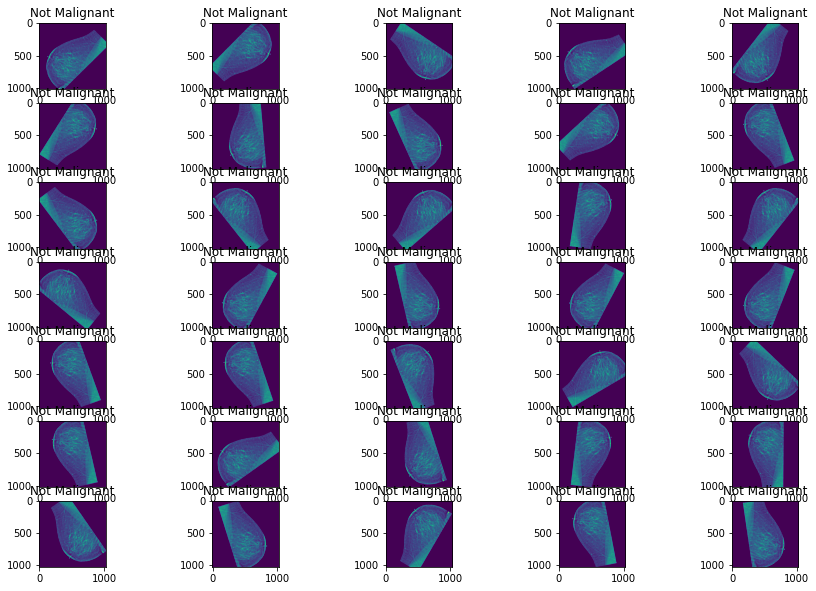

In [53]:

# get some training images
arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# Viewing data examples used for training
fig, axis = plt.subplots(7, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = train[5]
        ax.imshow(img_display(image)) # add image
        ax.set_title(str(arthopod_types[label.item()]))

In [ ]:
base_model = timm.create_model('efficientnetv2_s', num_classes = 1280, pretrained = True, in_chans = 1)
for param in base_model.parameters():
    param.requires_grad = False

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.base_model = base_model
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.base_model(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
#model = Net() # On CPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = Net().to(device) # On GPU
print(model)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 1, end_factor = 0.2, total_iters = 10)

In [ ]:
n_epochs = 8
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    #scheduler.step(epoch)
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device) # on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)

        pred = torch.sigmoid(outputs)
        target = target_.unsqueeze(1).float()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        pred = pred > 0.5
        accuracy = (target == pred).sum().item() / target.size(0)

        if (batch_idx) % 3 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * accuracy)
    train_loss.append(running_loss / total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * accuracy):.4f}')
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_loader):
            data_t, target_t = data_t.to(device), target_t.to(device) # on GPU
            outputs_t = model(data_t)
            pred_t = torch.sigmoid(outputs_t)
            target_t = target_t.unsqueeze(1).float()
            loss_t = criterion(pred_t, target_t)
            batch_loss += loss_t.item()
            pred_t = pred_t > 0.5
            accuracy_t = (target_t == pred_t).sum().item() / target_t.size(0)
        val_acc.append(100 * accuracy_t)
        val_loss.append(batch_loss / len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * accuracy_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'cancer_classification.pt')
            print('Detected network improvement, saving current model')
    model.train()

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label = 'train')
plt.plot(val_acc, label = 'validation')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)
plt.legend(loc = 'best')

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.title("Train - Validation Loss")
plt.plot(train_loss, label = 'train')
plt.plot(val_loss, label = 'validation')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('loss', fontsize = 12)
plt.legend(loc = 'best')

In [ ]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('cancer_classification.pt'))

In [ ]:
model.cpu().eval()
dataiter = iter(val_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image_visual, label_visual = val[i]
        image, label = images[i], labels[i]
        ax.imshow(img_display(image_visual.squeeze(0))) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = torch.sigmoid(output_)
        if output_.item() > 0.5:
            k = (label.item() == 1)
        else:
            k = (label.item() == 0)
        ax.set_title(str(arthopod_types[label.item()]) + ":" + str(k)) # add label